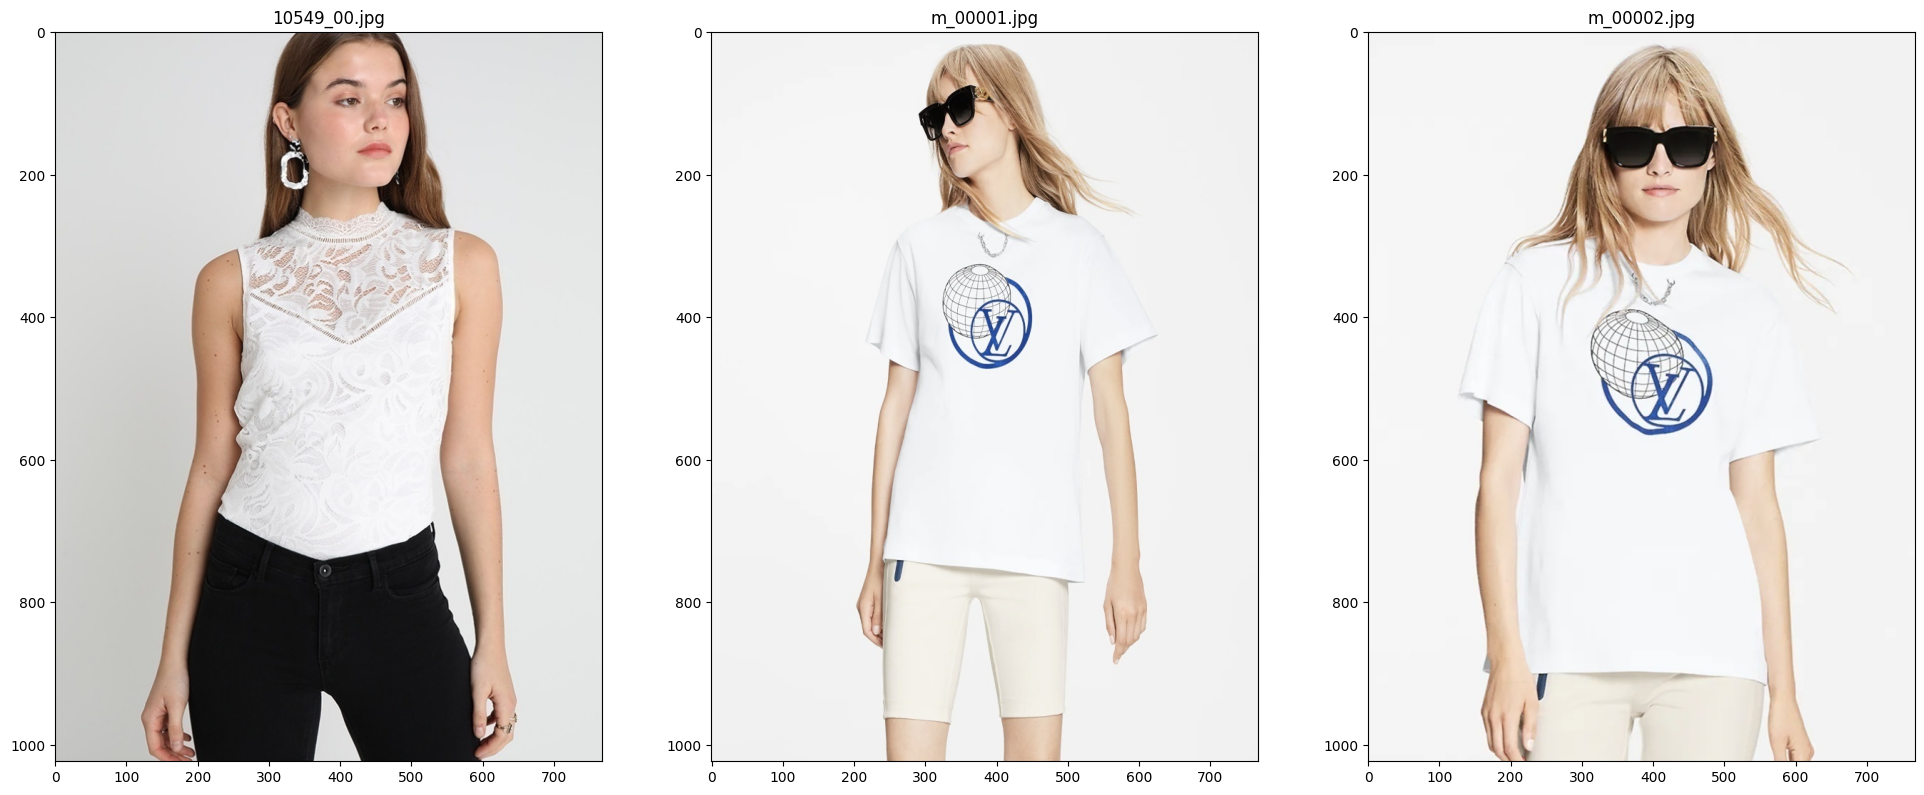

In [1]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

def show_imgs(imgs, horizon=True, h=24, w=12):
    plt.figure(figsize=(h, w), dpi=100)
    for i, img in enumerate(imgs):
        if horizon:
            sub_plt = plt.subplot(1, len(imgs), i+1)
        else:
            sub_plt = plt.subplot(len(imgs), 1, i+1)
        _, img_name = img.rsplit('/', 1)
        img = cv2.imread(img)
        sub_plt.imshow(img[:,:,::-1])
        sub_plt.set_title(img_name)

img_root_dir = Path('./datasets')
imgs = [ str(i) for i in img_root_dir.rglob('./test/image/*.jpg')]
imgs

show_imgs(imgs)

In [2]:
import torch
import torch.nn as nn
import torchgeometry as tgm

class opt:
    # 目标分辨率的 H、W
    load_height = 1024
    load_width = 768
    # human-parsing map classes
    semantic_nc = 13
    dataset_dir = './datasets/'
    dataset_mode = 'test'
    dataset_list = 'test_pairs.txt'
    


In [3]:
up = nn.Upsample(size=(opt.load_height, opt.load_width), mode='bilinear')
gauss = tgm.image.GaussianBlur((3, 3), (1, 1))
gauss.cuda()

GaussianBlur()

In [4]:
from torchvision import transforms
img_array = cv2.imread(imgs[0])
img_array
# HWC -> CHW and [0, 255] -> [0, 1]
img_tensor = transforms.ToTensor()(img_array)
# [0, 1] -> [-1, 1]: (input[chanel] - mean[chanel])/ std[chanel]
img_tensor = transforms.Normalize((.5, .5, .5), (.5, .5, .5))(img_tensor)

In [5]:
img_tensor.shape

torch.Size([3, 1024, 768])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


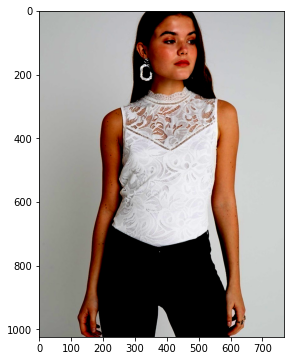

In [6]:
fig = plt.figure(figsize=(12,6))
plt.imshow(img_tensor.permute(1,2,0).numpy()[:,:,::-1])

In [7]:
from datasets import VITONDataset, VITONDataLoader
test_dataset = VITONDataset(opt)
# test_loader = VITONDataLoader(opt, test_dataset)

In [8]:
test_dataset[0]

/root/miniconda3/envs/jia/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


{'img_name': '10549_00.jpg',
 'c_name': {'unpaired': '00001.jpg'},
 'img': tensor([[[0.6784, 0.6784, 0.6784,  ..., 0.7176, 0.7176, 0.7176],
          [0.6784, 0.6784, 0.6784,  ..., 0.7176, 0.7176, 0.7176],
          [0.6784, 0.6784, 0.6784,  ..., 0.7176, 0.7176, 0.7176],
          ...,
          [0.5373, 0.5373, 0.5373,  ..., 0.7647, 0.7647, 0.7647],
          [0.5294, 0.5294, 0.5294,  ..., 0.7647, 0.7647, 0.7647],
          [0.5294, 0.5294, 0.5294,  ..., 0.7647, 0.7647, 0.7647]],
 
         [[0.6941, 0.6941, 0.6941,  ..., 0.7490, 0.7490, 0.7490],
          [0.6941, 0.6941, 0.6941,  ..., 0.7490, 0.7490, 0.7490],
          [0.6941, 0.6941, 0.6941,  ..., 0.7490, 0.7490, 0.7490],
          ...,
          [0.5373, 0.5373, 0.5373,  ..., 0.7961, 0.7961, 0.7961],
          [0.5294, 0.5294, 0.5294,  ..., 0.7961, 0.7961, 0.7961],
          [0.5294, 0.5294, 0.5294,  ..., 0.7961, 0.7961, 0.7961]],
 
         [[0.6863, 0.6863, 0.6863,  ..., 0.7412, 0.7412, 0.7412],
          [0.6863, 0.6863, 0.686

In [12]:
from PIL import Image
import numpy as np

test_clo = Image.open('./datasets/test/cloth/00001.jpg')
print(test_clo)
test_clo_resize = transforms.Resize(opt.load_width, interpolation=transforms.InterpolationMode.BILINEAR)(test_clo)
print(test_clo_resize)
np.array(test_clo_resize).shape

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1012x1006 at 0x7F7BAFCA6690>
<PIL.Image.Image image mode=RGBA size=772x768 at 0x7F7BAFC92F50>


(768, 772, 4)

In [14]:
test_mask = Image.open('./datasets/test/cloth-mask/00001.jpg')
test_mask_resize = transforms.Resize(opt.load_width, interpolation=transforms.InterpolationMode.NEAREST)(test_mask)
test_mask_resize = np.array(test_mask_resize)
print(test_mask_resize)
test_mask_resize = (test_mask_resize >= 128).astype(np.float32)
test_mask_resize

# test_mask_resize = torch.from_numpy(test_mask_resize)
# print(test_mask_resize)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 2 1 ... 0 0 0]
 [2 2 1 ... 0 0 0]
 [2 2 1 ... 0 0 0]]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
test_pose_rgb = Image.open('./datasets/test/openpose-img/10549_00_rendered.png')
print(test_pose_rgb)
test_pose_rgb = transforms.Resize(opt.load_width, interpolation=transforms.InterpolationMode.BILINEAR)(test_pose_rgb)
np.array(test_pose_rgb).shape

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x1024 at 0x7F7BAFC92510>


(1024, 768, 3)

In [187]:
import json
with open('./datasets/test/openpose-json/10549_00_keypoints.json', 'r') as f:
    pose_label = json.load(f)
    pose_data = pose_label['people'][0]['pose_keypoints_2d']

pose_data = np.array(pose_data)
print(len(pose_data))
pose_data = pose_data.reshape((-1, 3))[:,:2]
print(len(pose_data))
print(pose_data)

75
25
[[459.608  122.442 ]
 [411.402  346.141 ]
 [249.895  351.894 ]
 [215.97   618.172 ]
 [167.631  884.6   ]
 [572.947  329.269 ]
 [578.543  589.92  ]
 [615.367  859.143 ]
 [385.884  799.628 ]
 [283.84   799.651 ]
 [  0.       0.    ]
 [  0.       0.    ]
 [487.857  808.135 ]
 [  0.       0.    ]
 [  0.       0.    ]
 [414.198   99.533 ]
 [479.438   99.5429]
 [329.236  125.343 ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]]


## Huamn parsing(part segmentation)

1
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2 13 13 13 13 13  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2 13 13 13 13 13 13  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2 13 13 13 13 13 13 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2 13 13 13 13 13 13 13 13  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  2 13 13 13 13 13 13 13 13  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2 13 13 13 13 13 13 13 13 13 13  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2 13 13 13 13 13 13 13 13 13  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 

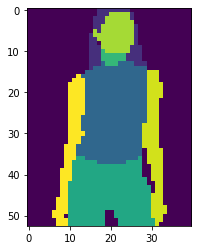

In [216]:
# load demo parsing image
parse = Image.open('./datasets/test/image-parse/10549_00.png').convert('L')

print(len(parse.split()))

#parse = transforms.Resize(opt.load_width, interpolation=transforms.InterpolationMode.NEAREST)(parse)
parse = transforms.Resize(40, interpolation=transforms.InterpolationMode.NEAREST)(parse)

parse_array = np.array(parse)
np.set_printoptions(edgeitems=1000, linewidth=1000)
print(parse_array)
print(parse_array.shape)
plt.imshow(parse_array)

#print(parse_array[789])

In [189]:
CIHP_CLASSES = ['background', 'hat', 'hair', 'glove', 'sunglasses', 'upperclothes',
               'dress', 'coat', 'socks', 'pants', 'tosor-skin', 'scarf', 'skirt',
               'face', 'leftArm', 'rightArm', 'leftLeg', 'rightLeg', 'leftShoe', 'rightShoe']
for k, v in enumerate(CIHP_CLASSES):
    print(k, v)

0 background
1 hat
2 hair
3 glove
4 sunglasses
5 upperclothes
6 dress
7 coat
8 socks
9 pants
10 tosor-skin
11 scarf
12 skirt
13 face
14 leftArm
15 rightArm
16 leftLeg
17 rightLeg
18 leftShoe
19 rightShoe


In [190]:
viton_classes = {
            0: ['background', [0, 10]],  # background, tosor-skin
            1: ['hair', [1, 2]],         # hat, hair
            2: ['face', [4, 13]],        # sunglasses, face
            3: ['upper', [5, 6, 7]],     # upperclothes, dress, coat
            4: ['bottom', [9, 12]],      # pants, skirt
            5: ['left_arm', [14]],       # leftArm
            6: ['right_arm', [15]],      # rightArm
            7: ['left_leg', [16]],       # leftLeg
            8: ['right_leg', [17]],      # rightLeg
            9: ['left_shoe', [18]],      # leftShoe
            10: ['right_shoe', [19]],    # rightShoe
            11: ['socks', [8]],          # socks
            12: ['noise', [3, 11]]       # glove, scarf
        }

In [191]:
# by Demo Input human parsing (附带了调色板信息的图片)
from PIL import Image
import numpy as np
test_parse_path = 'datasets/test/image-parse-bak/10549_00.png'
parse = Image.open(test_parse_path)
parse_a = np.asarray(parse)
print("parse_a shape:", parse_a.shape)
print(parse.mode, parse.info, parse.palette)

parse_a shape: (1024, 768)
P {} <PIL.ImagePalette.ImagePalette object at 0x7f7bad7b1410>


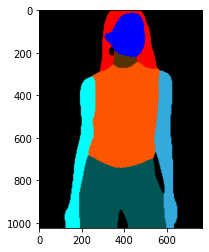

In [202]:
color_map = parse.getpalette()
plt.imshow(parse)

In [193]:
# color_map is list, len： 768 = 3 channel * 256 gray value
len(color_map)

768

In [194]:
# by CIHP-PGN inference （没有调色板信息的图片）
test_parse_path = 'datasets/test/image-parse/10549_00.png'
parse_02 = Image.open(test_parse_path)
parse_02_a = np.asarray(parse_02)
print("parse_02_a shape:", parse_02_a.shape)
print(parse_02.mode, parse_02.info, parse_02.palette)

parse_02_a shape: (1024, 768)
L {} None


In [195]:
# difference ratio
(parse_a != parse_02_a).astype(np.int32).reshape([-1]).sum()/len(parse_a.reshape([-1]))

0.01671600341796875

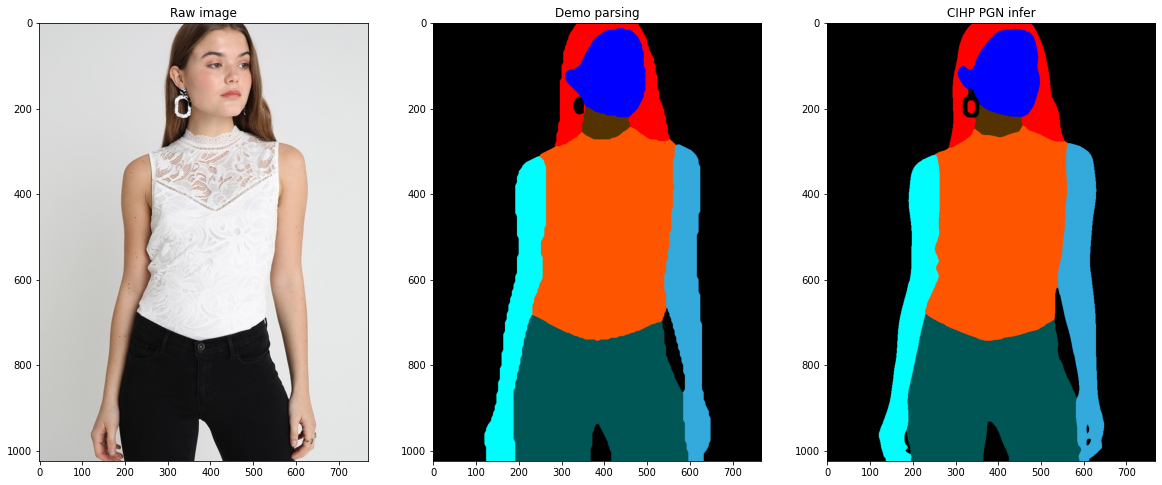

In [215]:
# 添加调色板信息，显示图片
parse_02.putpalette(color_map)
plt.figure(figsize=(20, 10), dpi=72)
plt.subplot(1,3,1)
plt.title('Raw image')
plt.imshow(Image.open('datasets/test/image/10549_00.jpg'))
plt.subplot(1,3,2)
plt.title("Demo parsing")
plt.imshow(parse)
plt.subplot(1,3,3)
plt.title("CIHP PGN infer")
plt.imshow(parse_02)

## openpose

In [206]:
import json
with open('./datasets/test/openpose-json/10549_00_keypoints.json', 'r', encoding='utf-8') as f:
    key_points = json.load(f)

In [207]:
key_points['people'][0].keys()

dict_keys(['person_id', 'pose_keypoints_2d', 'face_keypoints_2d', 'hand_left_keypoints_2d', 'hand_right_keypoints_2d', 'pose_keypoints_3d', 'face_keypoints_3d', 'hand_left_keypoints_3d', 'hand_right_keypoints_3d'])

In [208]:
# point format: x, y, confidence
print(key_points['people'][0]['pose_keypoints_2d'][:6])

# total keypoints: 25; 
print(len(key_points['people'][0]['pose_keypoints_2d'])/3)

[459.608, 122.442, 0.925274, 411.402, 346.141, 0.744845]
25.0


In [209]:
pose_img = Image.open('./datasets/test/openpose-img/10549_00_rendered.png')
pose_img.mode, pose_img.format

('RGB', 'PNG')

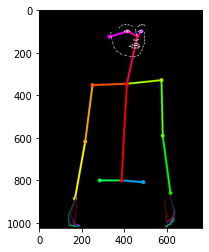

In [210]:
plt.imshow(pose_img)

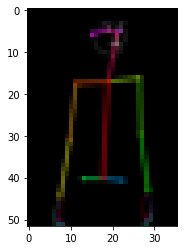

In [211]:
pose_img_re = pose_img.resize((36, 52))
plt.imshow(pose_img_re)

In [212]:
np.set_printoptions(edgeitems=1000, linewidth=1000)
pose_img_re_a = np.asarray(pose_img_re)
print(pose_img_re_a.shape)
print(pose_img_re_a[:,:,0])

(52, 36, 3)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   8  24  19  13  10  36  13   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   7  27  75   9  22  58   3   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1  43  65 103 119 138 115 116 115  14   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  11 153  80  27   0   0  31 173  20  16   0   0 

In [213]:
print(pose_img_re_a[:,:,1])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   8  25  22  13  10  38  13   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  12  15  39  11  28  37   2   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  15   5   0  14  46   5  44  54  15   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  15   8   0   0   0   4  25   6  18   0   0   0   0   0 

In [214]:
print(pose_img_re_a[:,:,2])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   8  24  20  13  10  35  13   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   7  26  64   9  25  69   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1  43  65 104 118 112  76  99 141  14   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  11 153  80  27   0   0  21  83  11  17   0   0   0   0   0 